# final results with systematical uncetainties

In [1]:
import sys; sys.path.insert(0, '../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline
%precision 3
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/paper-CCQEXSec/Figures/overlay_8.11/'

versions:
{   'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'beam off': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'beam on': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'data date': '2018_08_16',
    'overlay date': '2018_09_22'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.051017899728 = N(POT on beam)/N(POT MC)


## load extracted cross-sections and GENIE models predictions

In [2]:
Xsec_results_dicts = dict()
with open(Paths['1d Xsec'] + "PmuXsecs_1D.txt", 'rb') as infile:
    Xsec_results_dicts['mu'] = pickle.load(infile)
with open(Paths['1d Xsec'] + "PpXsecs_1D.txt", 'rb') as infile:
    Xsec_results_dicts['p'] = pickle.load(infile)
    
Xsec_dicts_genie = dict()
with open(Paths['1d Xsec'] + "Pmu_genie_Xsecs_1D.txt", 'rb') as infile:
    Xsec_dicts_genie['mu'] = pickle.load(infile)
with open(Paths['1d Xsec'] + "Pp_genie_Xsecs_1D.txt", 'rb') as infile:
    Xsec_dicts_genie['p'] = pickle.load(infile)

In [6]:
with open(Paths['systematics'] + "cut_sensitivty_systemaitcal_uncertainty.txt", 'rb') as infile: 
    Xsec_sys_unc_cuts = pickle.load(infile)
with open(Paths['systematics'] + "beam_flux_uncertainty_systemaitcal_uncertainty.txt", 'rb') as infile: 
    Xsec_sys_unc_beam_flux = pickle.load(infile)
POT_unc = 0.02 # 2% (proton flux measured in the two toroids agree to within 2%...)

## now draw the cross-sections

In [21]:
def draw_Xsecs(do_add_afro_genie=True, debug=0, particle='mu',do_with_ctu_bin=False,ticks_color='black',
               do_P=True, do_cos_theta=True, do_phi=True,figsize=(24,10),do_save_file=True):
    
    Xsec_dicts = Xsec_results_dicts[particle]
    Xsec_dicts_genie_particle = Xsec_dicts_genie[particle]
    
    figurename = 'Xsec_1D_P'+particle 
    for iXsec,(Xsec_title,Xsec_fname,remove_ctu_bin) in enumerate(zip(Xsec_ctu_titles,Xsec_fnames,remove_ctu_bools)):#{
        if remove_ctu_bin==False and do_with_ctu_bin==False: continue
            
        Xsec_dict = Xsec_dicts[Xsec_title]
        Xsec_genie_dict = Xsec_dicts_genie_particle[Xsec_title]

        fig=plt.figure(figsize=figsize)
        for ivar,observable in enumerate(['P'+particle,'cos(theta('+particle+'))']):#{
            var,vtrue,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
            ## We want to draw the cos\theta\mu cross-section with the last bin, and all the rest without the last bin...
            if "Pmu_cos_theta" in var: 
                Xsec_title = Xsec_ctu_titles[1]
                Xsec_dict = Xsec_dicts[Xsec_title]
                Xsec_genie_dict = Xsec_dicts_genie_particle[Xsec_title]
                Xsec_fname = Xsec_fnames[1]                                
            h = dict()
            h['Xsec'],h['Xsec err'] = Xsec_dict[observable],Xsec_dict[observable+' err']

            ax = fig.add_subplot(1,2,ivar+1)
            if do_add_afro_genie:#{
                for gname,ls,glabel in zip(genie_list,['-','--','-.',':'],genie_labels):#{
                    mystep(x=mid ,x_width=bin_width, 
                           y=Xsec_genie_dict[gname+' '+observable], 
                           y_width=Xsec_genie_dict[gname+' '+observable+' err'],
                           color='black',linestyle=ls,linewidth=3,label=glabel)
                #}
            #}            
            # ---------------------------------------- # 
            # systematical uncertainties
            Xsec_sys_unc_up, Xsec_sys_unc_dw, Xsec_tot_unc_up, Xsec_tot_unc_dw = get_sys_uncertainties(Xsec_sys_unc_cuts=Xsec_sys_unc_cuts,Xsec_sys_unc_beam_flux=Xsec_sys_unc_beam_flux,var=var,Xsec_fname=Xsec_fname,h=h)
            if debug:
                print 'Xsec_sys_unc_cuts_up,Xsec_sys_unc_flux_up,Xsec_sys_unc_up:',Xsec_sys_unc_cuts_up,Xsec_sys_unc_flux_up,Xsec_sys_unc_up
                print 'Xsec_sys_unc_up:',Xsec_sys_unc_up
            plt.errorbar(x=mid,xerr=0.5*bin_width,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o',markersize=15,label='data, this work') # data
            plt.errorbar(x=mid,xerr=0,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o',markersize=0,capsize=5,capthick=2) # + stat. uncertainties
            plt.errorbar(x=mid,xerr=0,y=h['Xsec'],yerr=[Xsec_tot_unc_dw,Xsec_tot_unc_up],color=Colors['beam on'],fmt='o',markersize=0,capsize=10,capthick=3) # + syst. uncertainties
            # ---------------------------------------- # 
            # axes labels
            set_axes(ax,xlabel,y_label=get_Xsec_label(vlabel=vlabel,units=units),fontsize=23,ticks_color=ticks_color
                     ,do_add_grid=True
                     ,do_add_legend=True if 'Pmu_cos_theta' in var else False                      
                     ,ylim=(0,1.1*np.max(ax.get_ylim()))
#                      ,title=Xsec_title
                    )
            # depict a line simboling the removal of the last cos(theta) bin
            if 'Pmu_cos_theta' in var: plt.plot([bins[-2],bins[-2]],ax.get_ylim(),'--',color='red')            
        #}
        plt.tight_layout(h_pad=0.0)
        if do_save_file:        save_figure(figures_path + 'Xsec_1D_'+particle+'_'+Xsec_fname+'.pdf')
    return 

saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/paper-CCQEXSec/Figures/overlay_8.11/Xsec_1D_mu_with_last_ctu_bin.pdf


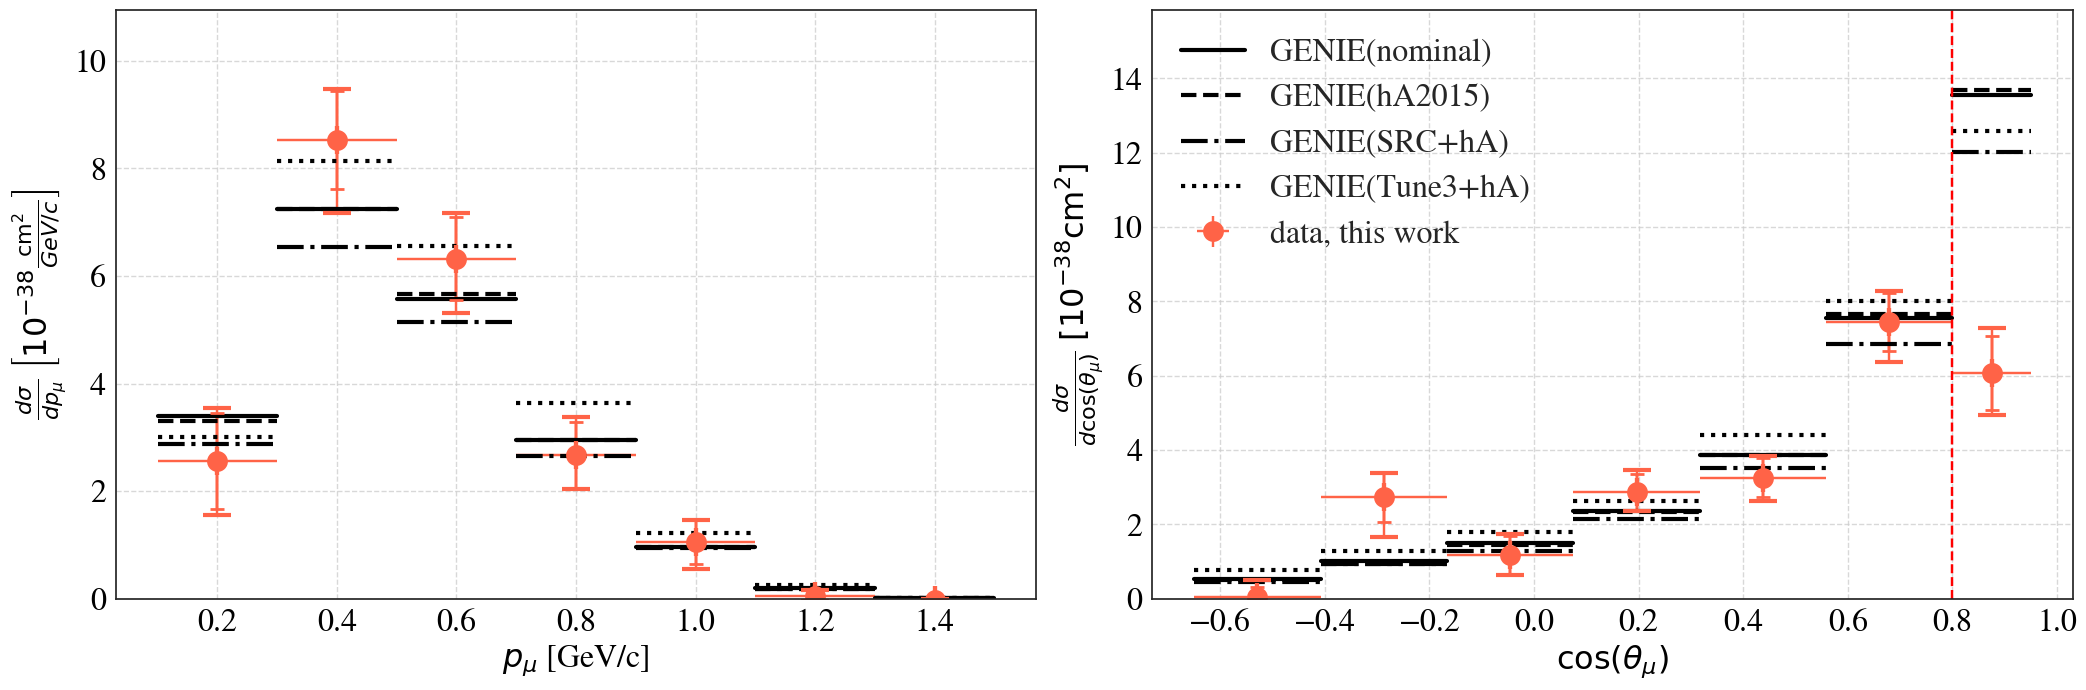

In [22]:
draw_Xsecs(do_add_afro_genie=True, debug=0, particle='mu', do_P=True, do_cos_theta=True, do_phi=True,figsize=(21,7),do_with_ctu_bin=False)

saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/paper-CCQEXSec/Figures/overlay_8.11/Xsec_1D_p_without_last_ctu_bin.pdf
saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/paper-CCQEXSec/Figures/overlay_8.11/Xsec_1D_p_with_last_ctu_bin.pdf


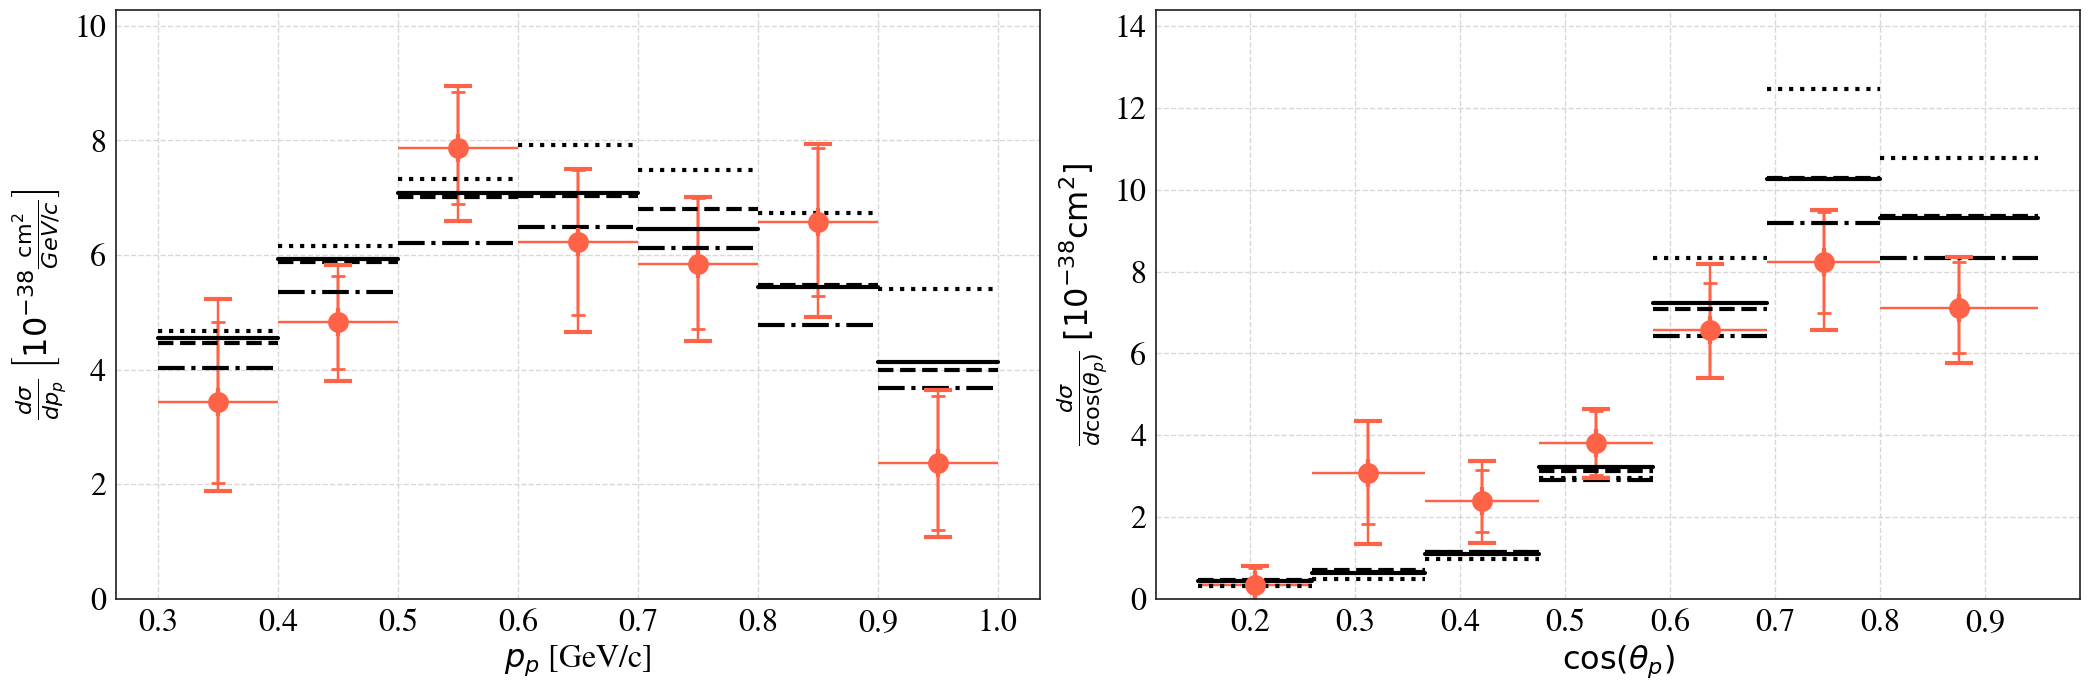

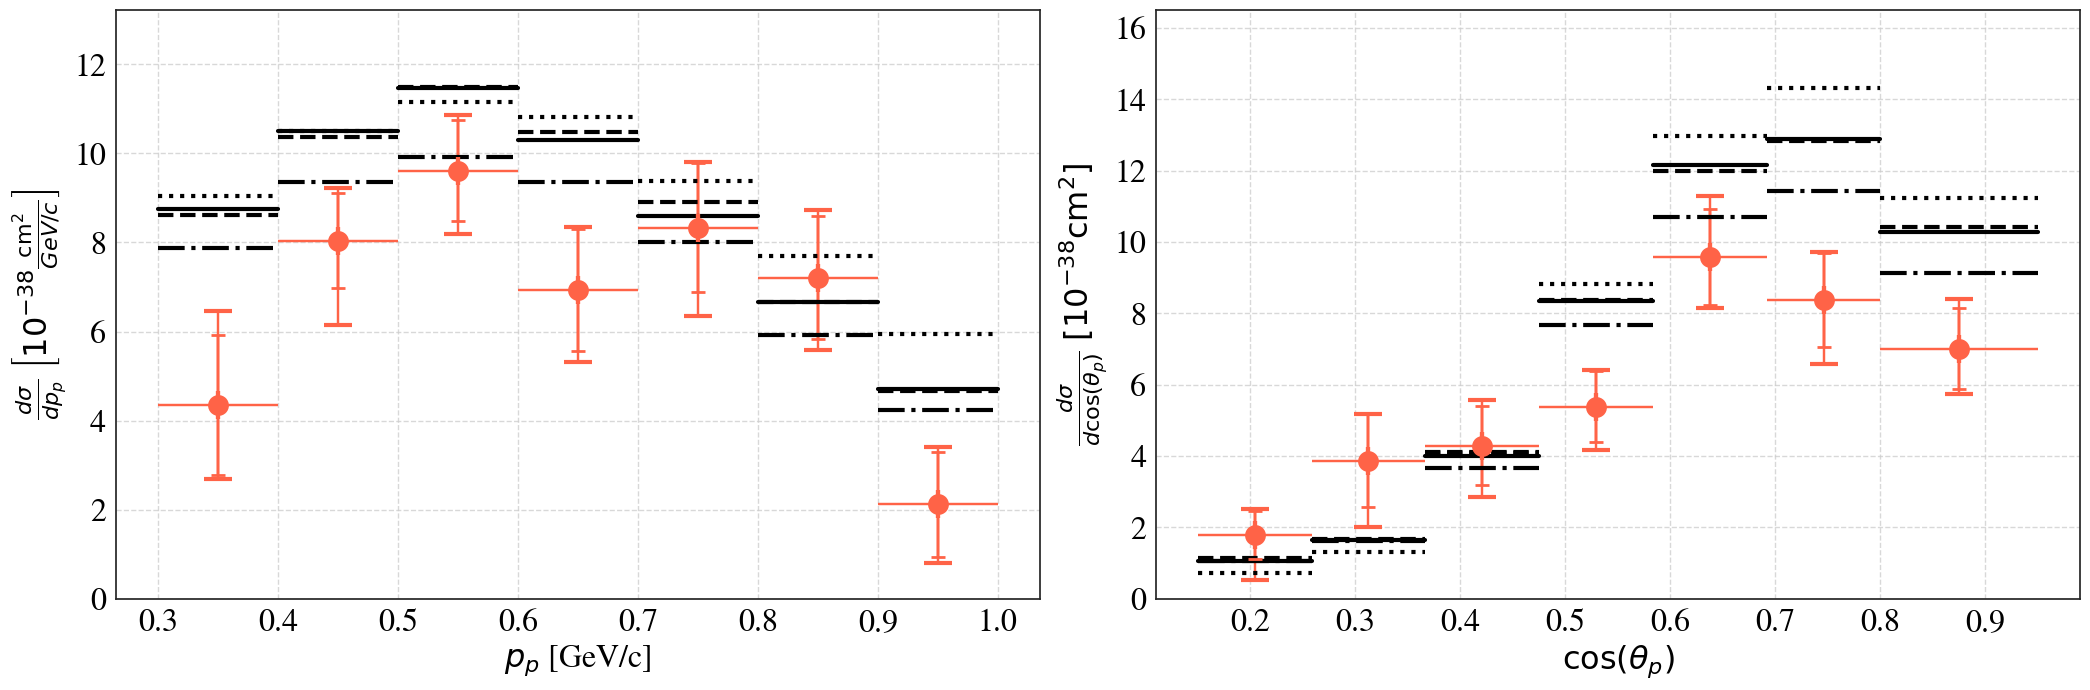

In [23]:
draw_Xsecs(do_add_afro_genie=True, debug=0, particle='p', do_P=True, do_cos_theta=True, do_phi=True,figsize=(21,7),do_with_ctu_bin=True)

# for joint-seminar, october-22, 2018

In [ ]:
particle = 'mu'
Xsec_dicts = Xsec_results_dicts[particle]
Xsec_dicts_genie_particle = Xsec_dicts_genie[particle]
Xsec_title = Xsec_ctu_titles[0]
Xsec_fname = Xsec_fnames[0]
            
Xsec_dict = Xsec_dicts[Xsec_title]
Xsec_genie_dict = Xsec_dicts_genie_particle[Xsec_title]

fig=plt.figure(figsize=(16,8))
observable = 'P'+particle
var,vtrue,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
h = dict()
h['Xsec'],h['Xsec err'] = Xsec_dict[observable],Xsec_dict[observable+' err']
h['Xsec beam on'],h['Xsec beam on err'] = Xsec_dict[observable+' beam on'],Xsec_dict[observable+' beam on err']
Xsec_sys_unc_up, Xsec_sys_unc_dw, Xsec_tot_unc_up, Xsec_tot_unc_dw = get_sys_uncertainties(Xsec_sys_unc_cuts=Xsec_sys_unc_cuts,var=var,Xsec_fname=Xsec_fname,h=h)


ax = fig.add_subplot(1,1,1)
for gname,ls,glabel in zip(genie_list,['-','--','-.',':'],genie_labels):#{
    mystep(x=mid ,x_width=bin_width, y=Xsec_genie_dict[gname+' '+observable], 
           y_width=Xsec_genie_dict[gname+' '+observable+' err'],           
           color='black',linestyle=ls,linewidth=3,label=glabel)

    
plt.errorbar(x=mid,xerr=0.5*bin_width,y=h['Xsec beam on'],yerr=h['Xsec beam on err'],color='blue'
             ,fmt='s',label='only selection criteria') # data
plt.errorbar(x=mid,xerr=0.5*bin_width,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on']
             ,fmt='o',label='full cross-section') # data
plt.errorbar(x=mid,xerr=0,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on']
             ,fmt='o',markersize=0,capsize=5,capthick=2) # + stat. uncertainties
plt.errorbar(x=mid,xerr=0,y=h['Xsec'],yerr=[Xsec_tot_unc_dw,Xsec_tot_unc_up],color=Colors['beam on']
             ,fmt='o',markersize=0,capsize=10,capthick=3) # + syst. uncertainties
set_axes(ax,xlabel,y_label=get_Xsec_label(vlabel=vlabel,units=units),fontsize=23,ticks_color='white'
                     ,do_add_grid=True
                     ,do_add_legend=True
                     ,ylim=(0,1.1*np.max(ax.get_ylim()))
                    )

In [ ]:
def draw_Xsecs(do_add_afro_genie=True, debug=0, particle='mu',do_with_ctu_bin=False,ticks_color='black',
               do_P=True, do_cos_theta=True, do_phi=True,figsize=(24,10),do_save_file=True):
    
    Xsec_dicts = Xsec_results_dicts[particle]
    Xsec_dicts_genie_particle = Xsec_dicts_genie[particle]
    
    for iXsec,(Xsec_title,Xsec_fname,remove_ctu_bin) in enumerate(zip(Xsec_ctu_titles,Xsec_fnames,remove_ctu_bools)):#{
        if remove_ctu_bin==False and do_with_ctu_bin==False: continue
            
        Xsec_dict = Xsec_dicts[Xsec_title]
        Xsec_genie_dict = Xsec_dicts_genie_particle[Xsec_title]

        for ivar,(observable) in enumerate(['P'+particle,'cos(theta('+particle+'))','phi('+particle+')']):#{
            var,vtrue,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
            ## We want to draw the cos\theta\mu cross-section with the last bin, and all the rest without the last bin...
            if "Pmu_cos_theta" in var: 
                Xsec_title = Xsec_ctu_titles[1]
                Xsec_dict = Xsec_dicts[Xsec_title]
                Xsec_genie_dict = Xsec_dicts_genie_particle[Xsec_title]
                Xsec_fname = Xsec_fnames[1]                
                
            h = dict()
            h['Xsec'],h['Xsec err'] = Xsec_dict[observable],Xsec_dict[observable+' err']

            fig=plt.figure(figsize=figsize)
            ax = fig.add_subplot(1,1,1)
            if do_add_afro_genie:#{
                for gname,ls,glabel in zip(genie_list,['-','--','-.',':'],genie_labels):#{
                    mystep(x=mid ,x_width=bin_width, 
                           y=Xsec_genie_dict[gname+' '+observable], 
                           y_width=Xsec_genie_dict[gname+' '+observable+' err'],
                           color='black',linestyle=ls,linewidth=3,label=glabel)
                #}
            #}            
            # ---------------------------------------- # 
            # systematical uncertainties
            Xsec_sys_unc_up, Xsec_sys_unc_dw, Xsec_tot_unc_up, Xsec_tot_unc_dw = get_sys_uncertainties(Xsec_sys_unc_cuts=Xsec_sys_unc_cuts,var=var,Xsec_fname=Xsec_fname,h=h)
            plt.errorbar(x=mid,xerr=0.5*bin_width,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o',label='data') # data
            plt.errorbar(x=mid,xerr=0,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o',markersize=0,capsize=5,capthick=2) # + stat. uncertainties
            plt.errorbar(x=mid,xerr=0,y=h['Xsec'],yerr=[Xsec_tot_unc_dw,Xsec_tot_unc_up],color=Colors['beam on'],fmt='o',markersize=0,capsize=10,capthick=3) # + syst. uncertainties

            # ---------------------------------------- # 
            # axes labels
            set_axes(ax,xlabel,y_label=get_Xsec_label(vlabel=vlabel,units=units),ticks_color=ticks_color
                     ,do_add_grid=True,fontsize=30
                     ,do_add_legend=True if 'Pmu_cos_theta' in var else False                      
                     ,ylim=(0,1.1*np.max(ax.get_ylim())))
            # depict a line for the removal of the last cos(theta) bin
            if 'Pmu_cos_theta' in var: plt.plot([bins[-2],bins[-2]],ax.get_ylim(),'--',color='red')            
        #}
        plt.tight_layout(h_pad=0.0)
    return 

In [ ]:
draw_Xsecs(do_add_afro_genie=True, debug=0, particle='mu',
           figsize=(12,8),do_with_ctu_bin=False,ticks_color='white',do_save_file=False)

In [ ]:
draw_Xsecs(do_add_afro_genie=True, debug=0, particle='p',
           figsize=(12,8),do_with_ctu_bin=False,ticks_color='white',do_save_file=False)